# Test Harness Development Notebook

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2

### Load & Prepare Data

In [2]:
data = pd.read_csv("../data/electricity-normalized.csv")

In [3]:
# specify columns to keep and if categorical
cols = (
    ("day", True),
    ("period", True),
    ("nswdemand", False),
    ("vicdemand", False),
    ("transfer", False),
    ("class", True),
)

data_clean = data[[col for col, _ in cols]].copy(deep=True)

# label encode categorical
catcols = (col for col, iscat in cols if iscat)

for col in catcols:
    data_clean[col] = LabelEncoder().fit_transform(data_clean[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


data_clean = categorize(data_clean, cols)


In [4]:
data_clean

,day,period,nswdemand,vicdemand,transfer,class
0,1,0,0.439155,0.422915,0.414912,1
1,1,1,0.415055,0.422915,0.414912,1
2,1,2,0.385004,0.422915,0.414912,1
3,1,3,0.314639,0.422915,0.414912,1
4,1,4,0.251116,0.422915,0.414912,0
...,...,...,...,...,...,...
45307,6,43,0.340672,0.255049,0.405263,0
45308,6,44,0.355549,0.241326,0.420614,0
45309,6,45,0.340970,0.247799,0.362281,0
45310,6,46,0.329366,0.345417,0.206579,1


### Experiment Development

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from test_harness.utils.utils import plot_experiment_error, plot_multiple_experiments

from test_harness.datasets.dataset import Dataset
from test_harness.experiments.experiment import Experiment
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.sqsi_experiment import SQSI_MRExperiment

In [6]:
column_mapping = {
    "target": "class",
    "numerical_features": ["nswdemand", "vicdemand"],
    "categorical_features": ["day", "period"],
}

ED_dataset = Dataset(
    full_df=data_clean, column_mapping=column_mapping, window_size=2500
)
model = RandomForestClassifier(n_estimators=10, random_state=42)
# model = SVC(C=0.8, random_state=42, probability=True)

In [10]:
%%time

baseline = BaselineExperiment(model=model, dataset=ED_dataset)
topline = ToplineExperiment(model=model, dataset=ED_dataset)
# sqsi_mr = SQSI_MRExperiment(model=model, dataset=ED_dataset, k=20, significance_thresh=0.001)

baseline.run()
topline.run()
# sqsi_mr.run()

# plot_experiment_error(baseline);
# plot_experiment_error(topline);

DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
DOING THIS!
CPU times: user 2.87 s, sys: 44.5 ms, total: 2.91 s
Wall time: 2.9 s


<AxesSubplot:title={'center':'Cumulative Score over Experiment \n             Label Expense: 40000 \n             Total Train Time: 0.44107985496520996'}, xlabel='0'>

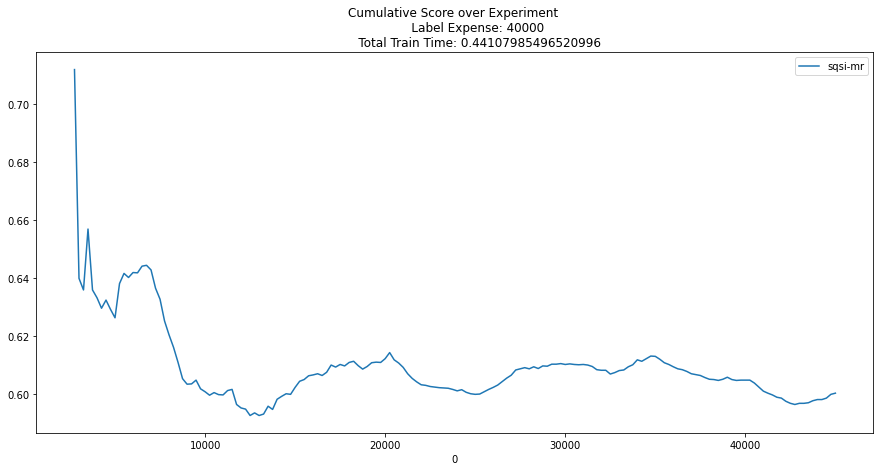

In [11]:
plot_experiment_error(sqsi_mr)

<AxesSubplot:title={'center':'Overall Score by Experiment'}, xlabel='0'>

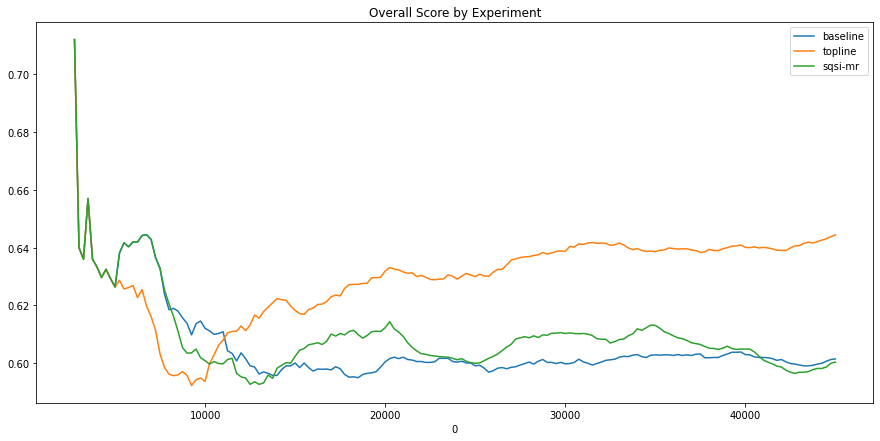

In [12]:
exps = [baseline, topline, sqsi_mr]
plot_multiple_experiments(exps)

In [ ]:
experiments = [{'name': 'baseline', 'experiment': BaselineExperiment(model=model, dataset=ED_dataset)},
               {'name': 'topline', 'experiment': ToplineExperiment(model=model, dataset=ED_dataset)}]

## SQSI Development

In [9]:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [12]:
test_data = data_clean[:10]

In [13]:
test_data

,day,period,nswdemand,vicdemand,transfer,class
0,1,0,0.439155,0.422915,0.414912,1
1,1,1,0.415055,0.422915,0.414912,1
2,1,2,0.385004,0.422915,0.414912,1
3,1,3,0.314639,0.422915,0.414912,1
4,1,4,0.251116,0.422915,0.414912,0
5,1,5,0.207528,0.422915,0.414912,0
6,1,6,0.171824,0.422915,0.414912,0
7,1,7,0.152782,0.422915,0.414912,0
8,1,8,0.134930,0.422915,0.414912,0
9,1,9,0.140583,0.422915,0.414912,0


In [14]:
def split_df(df, label_col):
    """Splits the features from labels in a dataframe, returns both"""
    return df.drop(label_col, axis=1), df[label_col]

In [15]:
X, y = split_df(test_data, label_col='class')

In [16]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)



In [20]:
import numpy as np
def make_kfold_predictions(X, y, k):
    """A KFold version of LeaveOneOut predictions.
    
    Rather than performing exhaustive leave-one-out methodology to get predictions
    for each observation, we use a less exhaustive KFold approach.
    
    When k == len(X), this is equivalent to LeaveOneOut, expensive, but robust. Reducing k
    saves computation, but reduces robustness of model.
    
    Args:
        X (pd.Dataframe) - features in evaluation window
        y (pd.Series) - labels in evaluation window
        k (int) - number of folds
    
    Returns:
        preds (np.array) - an array of predictions for each X in the input (NOT IN ORDER OF INPUT)
        
    
    """

    skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
    
    preds = np.array([])
    for train_indicies, test_indicies in skf.split(X, y):

        # instantiate training pipeline
        pipe = Pipeline(
                    steps=[
                                ("scaler", MinMaxScaler()),
                                ("clf", model),
                            ]
                        )
        # fit it
        pipe.fit(X.iloc[train_indicies], y.iloc[train_indicies])

        # score it on this Kfold's test data
        y_preds_split = pipe.predict_proba(X.iloc[test_indicies])
        y_preds_split_posclass_proba = y_preds_split[:, 1]

        preds = np.append(preds, y_preds_split_posclass_proba)
        
    return preds 

In [ ]:
def make_leaveoneout_predictions(X, y):
    
    loo = LeaveOneOut()
    
    preds = np.array([])
    for train_indicies, test_indicies in skf.split(X, y):
        
        # instantiate training pipeline
        pipe = Pipeline(
                    steps=[
                                ("scaler", MinMaxScaler()),
                                ("clf", model),
                            ]
                        )
        # fit it
        pipe.fit(X.iloc[train_indicies], y.iloc[train_indicies])

        # score it on this Kfold's test data
        y_preds_split = pipe.predict_proba(X.iloc[test_indicies])
        y_preds_split_posclass_proba = y_preds_split[:, 1]

        preds = np.append(preds, y_preds_split_posclass_proba)

    
    

In [22]:
preds = make_kfold_predictions(X, y, 3)

In [23]:
preds

array([0.9, 0.9, 0.1, 0. , 1. , 0.1, 0. , 1. , 0. , 0. ])

In [24]:
y

0    1
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: class, dtype: category
Categories (2, int64): [0, 1]

In [101]:
len(preds)

100

In [86]:
loo_preds.shape

(100,)

In [89]:
train_indicies

array([ 0,  1,  4,  5,  7,  8,  9, 10, 12, 13, 15, 17, 18, 20, 22, 23, 24,
       25, 27, 28, 29, 30, 31, 32, 35, 38, 39, 40, 41, 43, 44, 45, 47, 52,
       53, 54, 55, 56, 57, 59, 60, 62, 64, 65, 67, 68, 69, 70, 72, 73, 74,
       75, 76, 77, 78, 79, 81, 82, 85, 89, 90, 92, 93, 95, 96, 97, 99])

In [72]:
y_preds_split

array([[1.  , 0.  ],
       [0.95, 0.05],
       [0.92, 0.08],
       [0.26, 0.74],
       [0.29, 0.71],
       [0.44, 0.56],
       [0.65, 0.35],
       [0.78, 0.22],
       [0.91, 0.09],
       [0.96, 0.04],
       [0.74, 0.26],
       [0.85, 0.15],
       [0.7 , 0.3 ],
       [0.19, 0.81],
       [0.19, 0.81],
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.97, 0.03],
       [0.36, 0.64],
       [1.  , 0.  ],
       [0.87, 0.13],
       [0.9 , 0.1 ],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.78, 0.22],
       [0.66, 0.34],
       [0.98, 0.02],
       [0.99, 0.01],
       [0.63, 0.37],
       [0.7 , 0.3 ],
       [0.5 , 0.5 ],
       [0.35, 0.65],
       [0.2 , 0.8 ]])

In [77]:
y_preds_split[:, 1]

array([0.  , 0.05, 0.08, 0.74, 0.71, 0.56, 0.35, 0.22, 0.09, 0.04, 0.26,
       0.15, 0.3 , 0.81, 0.81, 0.01, 0.  , 0.03, 0.64, 0.  , 0.13, 0.1 ,
       0.01, 0.01, 0.03, 0.22, 0.34, 0.02, 0.01, 0.37, 0.3 , 0.5 , 0.65,
       0.8 ])

In [74]:
pipe.classes_

array([0, 1])

In [73]:
y_preds_split.shape

(34, 2)

In [58]:
X.iloc[train_indicies]

,day,period,nswdemand,vicdemand,transfer
0,1,0,0.439155,0.422915,0.414912
1,1,1,0.415055,0.422915,0.414912
2,1,2,0.385004,0.422915,0.414912
3,1,3,0.314639,0.422915,0.414912
4,1,4,0.251116,0.422915,0.414912
...,...,...,...,...,...
93,2,45,0.435138,0.422915,0.414912
94,2,46,0.456412,0.422915,0.414912
97,3,1,0.429485,0.422915,0.414912
98,3,2,0.399286,0.422915,0.414912


In [56]:
X

,day,period,nswdemand,vicdemand,transfer
0,1,0,0.439155,0.422915,0.414912
1,1,1,0.415055,0.422915,0.414912
2,1,2,0.385004,0.422915,0.414912
3,1,3,0.314639,0.422915,0.414912
4,1,4,0.251116,0.422915,0.414912
...,...,...,...,...,...
95,2,47,0.449866,0.422915,0.414912
96,3,0,0.448230,0.422915,0.414912
97,3,1,0.429485,0.422915,0.414912
98,3,2,0.399286,0.422915,0.414912


In [ ]:
for train, test in skf.split(X, y):

In [52]:
train

array([ 0,  1,  4,  5,  7,  8,  9, 10, 12, 13, 15, 17, 18, 20, 22, 23, 24,
       25, 27, 28, 29, 30, 31, 32, 35, 38, 39, 40, 41, 43, 44, 45, 47, 52,
       53, 54, 55, 56, 57, 59, 60, 62, 64, 65, 67, 68, 69, 70, 72, 73, 74,
       75, 76, 77, 78, 79, 81, 82, 85, 89, 90, 92, 93, 95, 96, 97, 99])

In [53]:
test

array([ 2,  3,  6, 11, 14, 16, 19, 21, 26, 33, 34, 36, 37, 42, 46, 48, 49,
       50, 51, 58, 61, 63, 66, 71, 80, 83, 84, 86, 87, 88, 91, 94, 98])

In [41]:
t.shape

(66,)

In [43]:
import numpy as np

In [44]:
np.bincount()

TypeError: bincount() missing 1 required positional argument: 'x'